In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import arviz as az
import pybeam.default as pbd

# modify figure text settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({ 'mathtext.default' : 'regular' })


In [2]:
# define model
model = {'type' : 'base',    # model type ('base' or 'ugm'). Six model keys needed with value 'base'.
        'sigma' : 1.0,       # sets sigma, the scaling parameter
    'threshold' : 'weibull', # sets threshold type (fixed, linear, exponential, or weibull)
      'leakage' : False,     # if True, drift rate has leaky integration
        'delay' : False,     # if True, decision threshold motion is delayed (only for non-fixed thresholds)
'contamination' : False}     # if True, uniform contamination added to model

# parameters for logistic-like weibull function
phi_log = {'t_nd' : 0.25,          # non-decision time
              'w' : 0.5,           # relative start point
             'mu' : 1.0,           # drift rate
              'a' : 1.0,           # decision threshold location
           'lamb' : np.log10(1.0), # log10 of weibull shape parameter
          'kappa' : np.log10(3.0), # log10 of weibull scale parameter
              'c' : -1.0}          # weibull collapse parameter

# simulate logistic data set
rt_log = pbd.simulate_model(N_sims = 500, 
                             model = model, 
                               phi = phi_log,
                              seed = 234)
           
# parameters for exponential-like weibull function
phi_exp = {'t_nd' : 0.25,            # non-decision time
              'w' : 0.5,             # relative start point
             'mu' : 1.0,             # drift rate
              'a' : 1.0,             # decision threshold location
           'lamb' : np.log10(5.0),   # log10 of weibull shape parameter
          'kappa' : np.log10(0.666), # log10 of weibull scale parameter
              'c' : -1.0}            # weibull collapse parameter

# simulate exponential data set
rt_exp = pbd.simulate_model(N_sims = 500, 
                             model = model, 
                               phi = phi_exp,
                              seed = 234)

# define model priors
p = {'pt_nd' : 'Uniform("t_nd", lower = 0.0, upper = 0.75)',
        'pw' : 'Uniform("w", lower = 0.3, upper = 0.7)',
       'pmu' : 'Uniform("mu", lower = -5.0, upper = 5.0)', 
        'pa' : 'Uniform("a", lower = 0.25, upper = 2.0)',
     'plamb' : 'Uniform("lamb", lower = -1.0, upper = 2.0)',
    'pkappa' : 'Uniform("kappa", lower = -1.0, upper = 2.0)',
        'pc' : -1.0}


In [3]:
# define model condition
c = {'rt' : rt_log,
   't_nd' : 'pt_nd',
      'w' : 'pw',
     'mu' : 'pmu',
      'a' : 'pa',
   'lamb' : 'plamb',
  'kappa' : 'pkappa',
      'c' : 'pc'}

# load conditions into dictionary
cond = {0 : c}

# run parameter inference
trace = pbd.inference(model = model,
                     priors = p,
                 conditions = cond,
                    samples = 25000,
                     chains = 3,
                      cores = 3,
                  file_name = 'weibull_log')


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [kappa, lamb, a, mu, w, t_nd]


Sampling 3 chains for 0 tune and 25_000 draw iterations (0 + 75_000 draws total) took 42 seconds.


In [4]:
# define model condition
c = {'rt' : rt_exp,
   't_nd' : 'pt_nd',
      'w' : 'pw',
     'mu' : 'pmu',
      'a' : 'pa',
   'lamb' : 'plamb',
  'kappa' : 'pkappa',
      'c' : 'pc'}

# load conditions into dictionary
cond = {0 : c}

# run parameter inference
trace = pbd.inference(model = model,
                     priors = p,
                 conditions = cond,
                    samples = 50000,
                     chains = 3,
                      cores = 3,
                  file_name = 'weibull_exp')


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [kappa, lamb, a, mu, w, t_nd]


Sampling 3 chains for 0 tune and 50_000 draw iterations (0 + 150_000 draws total) took 77 seconds.


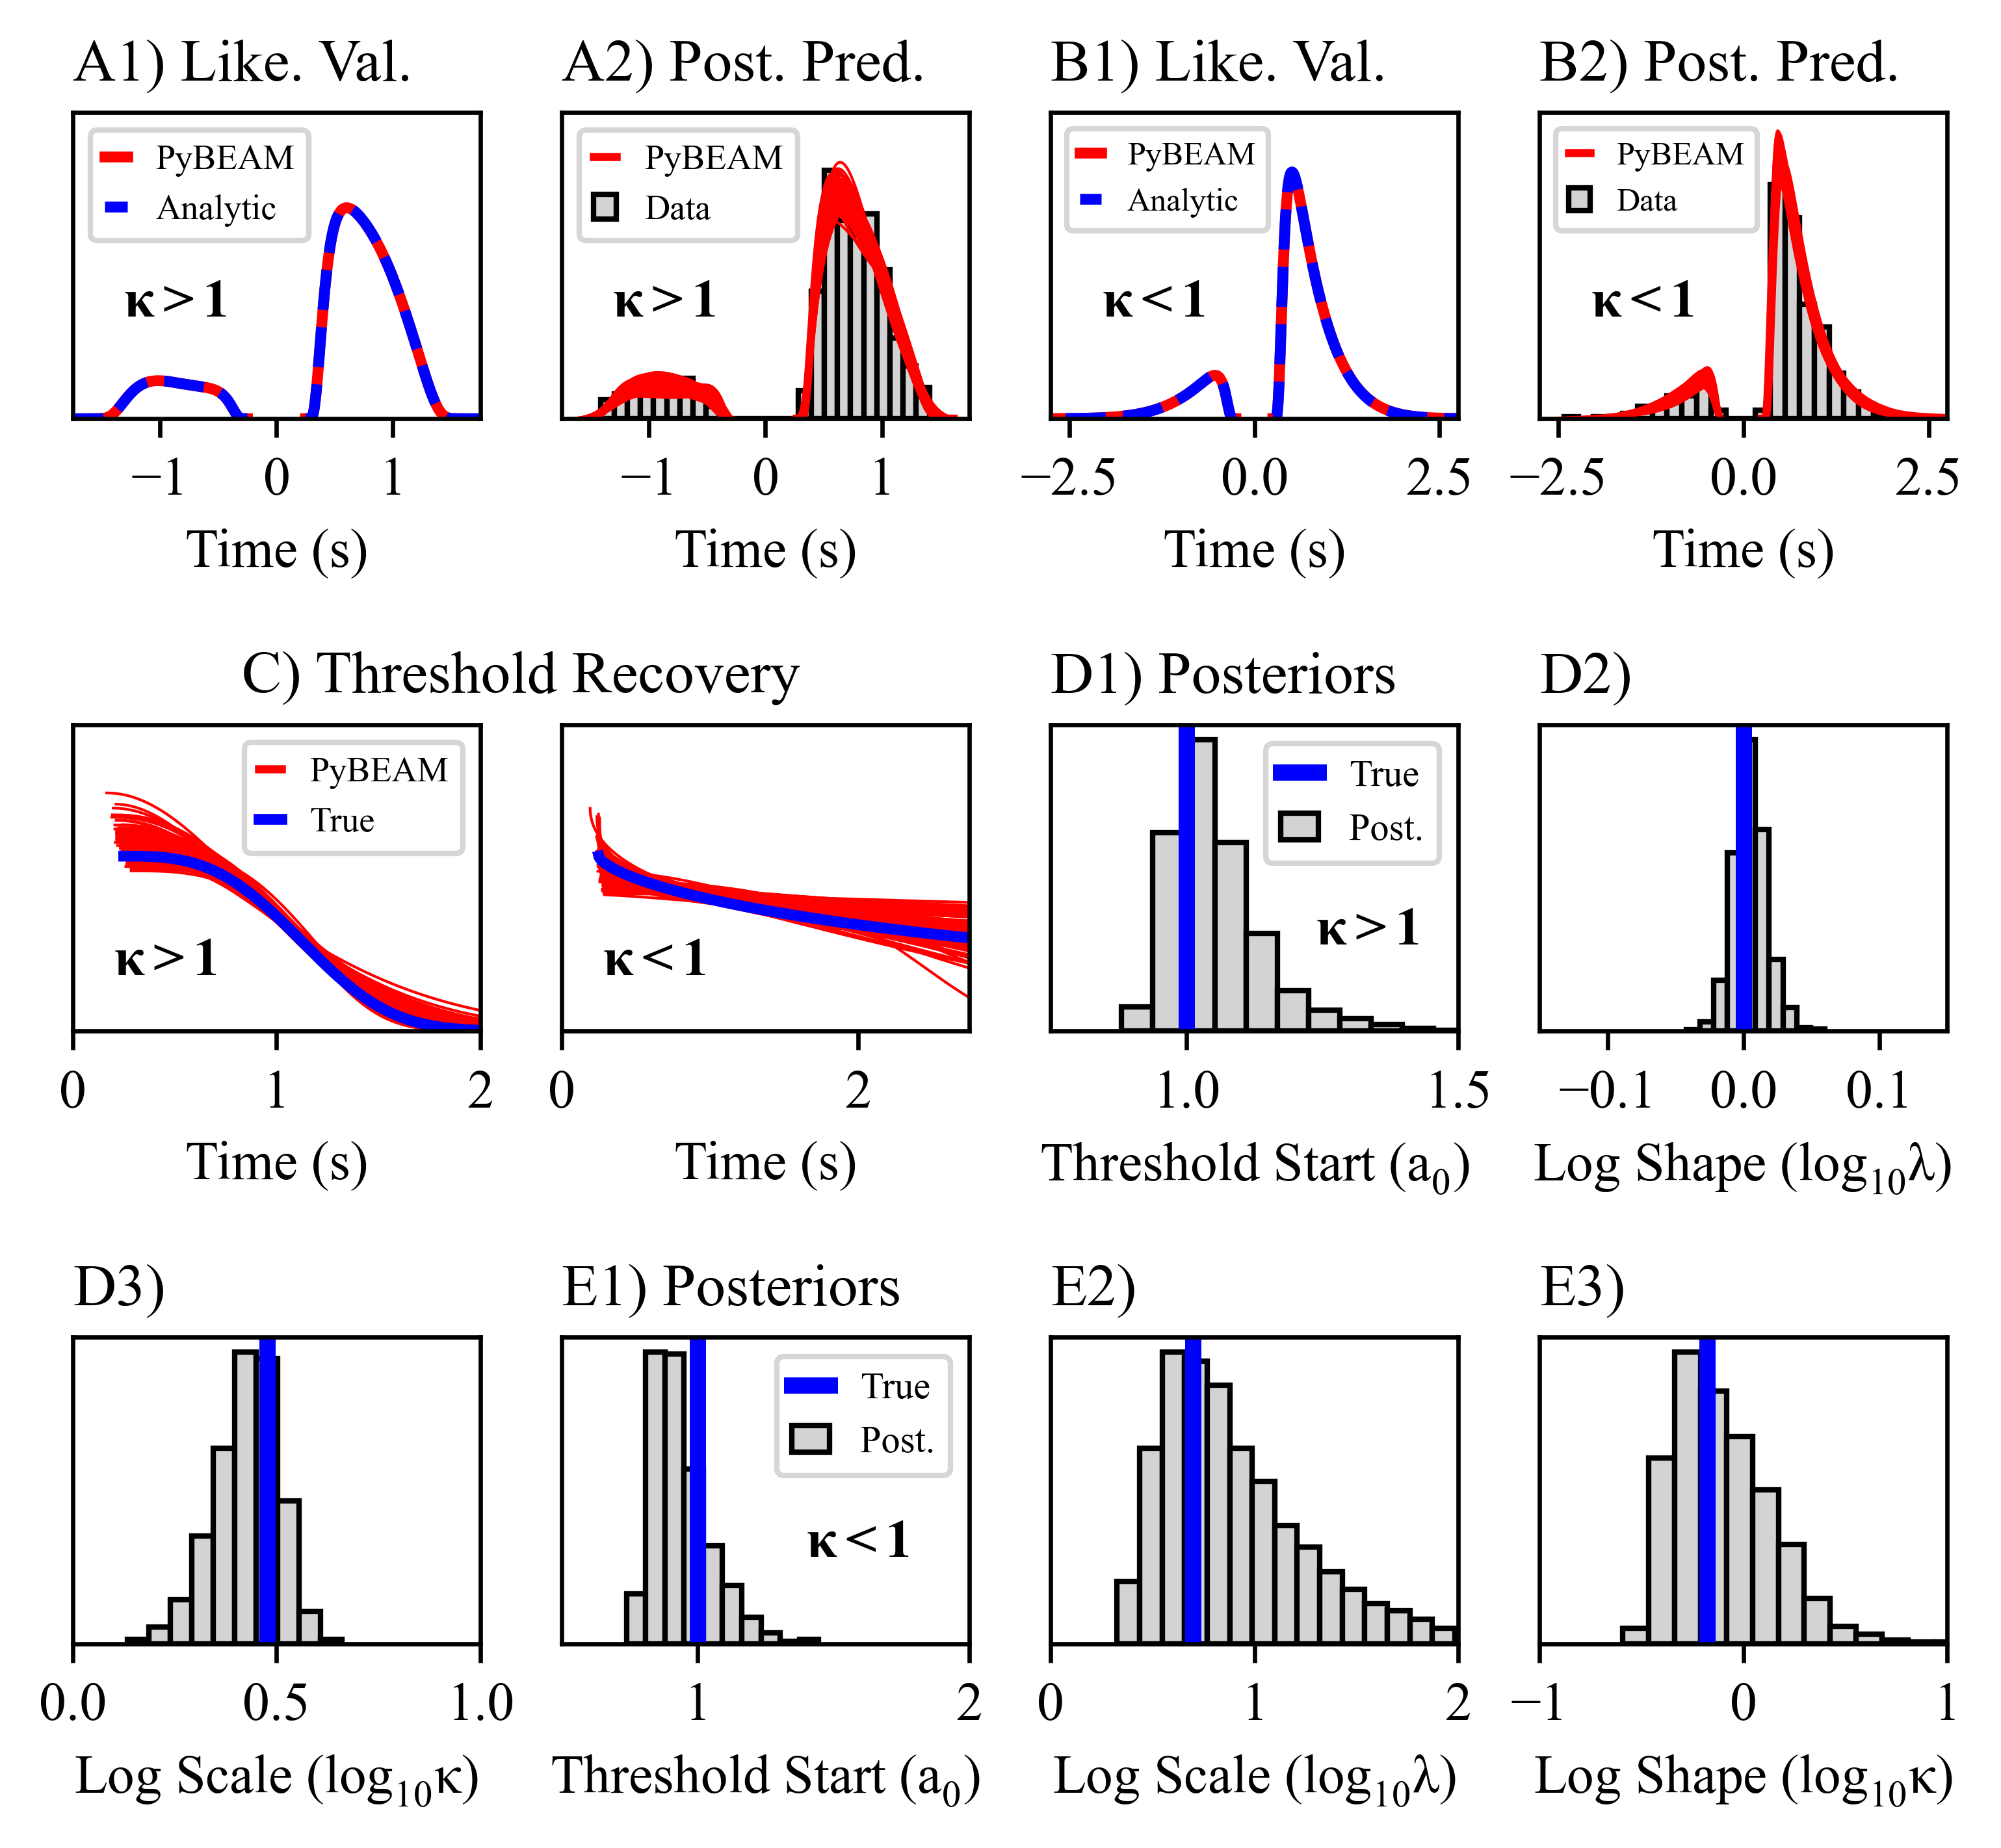

In [9]:
# -------------------------------------------------- #
# define figure
# -------------------------------------------------- #

fig, axs = plt.subplots(3, 4, figsize=(6.2, 5.2), dpi=600);
plt.subplots_adjust(hspace=1.0)

# -------------------------------------------------- #
# load trace data
# -------------------------------------------------- #

# weibull log-like trace
file_name = 'weibull_log'
burnin = 12500
trace = az.from_netcdf(file_name + '.nc')
trace = trace.sel(draw=slice(burnin,None))
trace = trace.posterior.stack(draws=("chain", "draw"))

t_nd_log = trace.t_nd.values
w_log = trace.w.values
mu_log = trace.mu.values
a_log = trace.a.values
lamb_log = trace.lamb.values
kappa_log = trace.kappa.values

# weibull exp-like trace
file_name = 'weibull_exp'
burnin = 25000
trace = az.from_netcdf(file_name + '.nc')
trace = trace.sel(draw=slice(burnin,None))
trace = trace.posterior.stack(draws=("chain", "draw"))

t_nd_exp = trace.t_nd.values
w_exp = trace.w.values
mu_exp = trace.mu.values
a_exp = trace.a.values
lamb_exp = trace.lamb.values
kappa_exp = trace.kappa.values

# -------------------------------------------------- #
# generate panel [0,0]
# -------------------------------------------------- #

model_rt = pbd.model_rt(model = model, phi = phi_log)
axs[0,0].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'red', linewidth = 2.0)
axs[0,0].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'red', linewidth = 2.0, label = '_nolegend_')

# import analytic solutions
t_log = np.loadtxt('t_log.csv', delimiter = ',')
rt_upper_log = np.loadtxt('rt_upper_log.csv', delimiter = ',')
rt_lower_log = np.loadtxt('rt_lower_log.csv', delimiter = ',')
axs[0,0].plot(t_log + phi_log['t_nd'], rt_upper_log, color = 'b', linestyle = '--', linewidth = 2.0)
axs[0,0].plot(-(t_log + phi_log['t_nd']), rt_lower_log, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2.0)

axs[0,0].set_xlim(-1.75, 1.75)
axs[0,0].set_title('A1) Like. Val.', loc = 'left', fontsize = 11)
axs[0,0].set_xlabel('Time (s)')
leg00 = axs[0,0].legend(['PyBEAM', 'Analytic'], fontsize = 6.5, handlelength = 0.65, loc = 'upper left')

# -------------------------------------------------- #
# generate panel [0,1]
# -------------------------------------------------- #

# plot logistic weibull posterior predictive
rt_log_all = np.concatenate((rt_log['rt_upper'], -rt_log['rt_lower']))
axs[0,1].hist(rt_log_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');

N_pp = 100
for ii in range(N_pp):
    
    ind = np.random.randint(0, len(t_nd_log))
    t_nd_ind = t_nd_log[ind]
    w_ind = w_log[ind]
    mu_ind = mu_log[ind]
    a_ind = a_log[ind]
    lamb_ind = lamb_log[ind]
    kappa_ind = kappa_log[ind]   
    
    phi_temp = {'t_nd' : t_nd_ind,
                   'w' : w_ind,
                  'mu' : mu_ind,
                   'a' : a_ind,
                'lamb' : lamb_ind,
               'kappa' : kappa_ind,
                   'c' : -1.0}
       
    rt_model = pbd.model_rt(model = model, phi = phi_temp)
    if (ii == 0):
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')
    
axs[0,1].set_xlim(-1.75, 1.75)
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_title('A2) Post. Pred.', loc = 'left', fontsize = 11)
axs[0,1].legend(['PyBEAM', 'Data'], fontsize = 6.5, loc = 'upper left', handlelength = 0.65)

# -------------------------------------------------- #
# generate panel [1,0]
# -------------------------------------------------- #

# plot logistic weibull boundary predictive

t = np.linspace(0.0, 2.5, 10000)

N_pp = 100
for ii in range(N_pp):
    ind = np.random.randint(0, len(t_nd_log))
    t_nd_ind = t_nd_log[ind]
    a_ind = a_log[ind]
    lamb_ind = 10**lamb_log[ind]
    kappa_ind = 10**kappa_log[ind]    
    bu = a_ind - a_ind*( 1.0 - np.exp( -(t/lamb_ind)**(kappa_ind) ) )
    if (ii == 0):
        axs[1,0].plot(t + t_nd_ind, bu, color = 'r')
    else:
        axs[1,0].plot(t + t_nd_ind, bu, color = 'r', linewidth = 0.5, label = '_nolegend_')

t_nd = phi_log['t_nd']
a = phi_log['a']
lamb = 10**phi_log['lamb']
kappa = 10**phi_log['kappa']
bu = a - a*( 1.0 - np.exp( -(t/lamb)**(kappa) ) )  
axs[1,0].plot(t + t_nd, bu, color = 'b', linewidth = 2);
        
axs[1,0].legend(['PyBEAM', 'True'], fontsize = 6.5, loc = 'upper right', handlelength = 0.65)
axs[1,0].set_title('C) Threshold Recovery', fontsize = 11, x = 1.1)
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylim(0.0, 1.75)
axs[1,0].set_xlim(0.0, 2.0)

# -------------------------------------------------- #
# generate panel [0,2]
# -------------------------------------------------- #

# simulate exponential weibull validation values
model_rt = pbd.model_rt(model = model, phi = phi_exp)
axs[0,2].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'red', linewidth = 2)
axs[0,2].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'red', linewidth = 2, label = '_nolegend_')

t_exp = np.loadtxt('t_exp.csv', delimiter = ',')
rt_upper_exp = np.loadtxt('rt_upper_exp.csv', delimiter = ',')
rt_lower_exp = np.loadtxt('rt_lower_exp.csv', delimiter = ',')
axs[0,2].plot(t_exp + phi_exp['t_nd'], rt_upper_exp, color = 'b', linestyle = '--', linewidth = 2)
axs[0,2].plot(-(t_exp + phi_exp['t_nd']), rt_lower_exp, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2)

axs[0,2].set_title('B1) Like. Val.', loc = 'left', fontsize = 11)
axs[0,2].set_xlabel('Time (s)')
axs[0,2].legend(['PyBEAM', 'Analytic'], fontsize = 6.0, loc = 'upper left', handlelength = 0.65)
axs[0,2].set_xlim([-2.75, 2.75])

# -------------------------------------------------- #
# generate panel [0,3]
# -------------------------------------------------- #

# plot exp weibull posterior predictive
rt_exp_all = np.concatenate((rt_exp['rt_upper'], -rt_exp['rt_lower']))
axs[0,3].hist(rt_exp_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');

N_pp = 100
for ii in range(N_pp):
    ind = np.random.randint(0, len(t_nd_exp))
    t_nd_ind = t_nd_exp[ind]
    w_ind = w_exp[ind]
    mu_ind = mu_exp[ind]
    a_ind = a_exp[ind]
    lamb_ind = lamb_exp[ind]
    kappa_ind = kappa_exp[ind]   
    
    phi_temp = {'t_nd' : t_nd_ind,
                   'w' : w_ind,
                  'mu' : mu_ind,
                   'a' : a_ind,
                'lamb' : lamb_ind,
               'kappa' : kappa_ind,
                   'c' : -1.0}
    
    rt_model = pbd.model_rt(model = model, phi = phi_temp)
    if (ii == 0):
        axs[0,3].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,3].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,3].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,3].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')

axs[0,3].set_xlabel('Time (s)')
axs[0,3].set_xlim([-2.75, 2.75])
axs[0,3].set_title('B2) Post. Pred.', loc = 'left', fontsize = 11)
axs[0,3].legend(['PyBEAM', 'Data'], fontsize = 6.0, loc = 'upper left', handlelength = 0.65)

# -------------------------------------------------- #
# generate panel [1,1]
# -------------------------------------------------- #

# plot exponential weibull boundary predictive

t = np.linspace(0.0, 2.5, 10000)

N_pp = 100
for ii in range(N_pp):
    ind = np.random.randint(0, len(t_nd_exp))
    t_nd_ind = t_nd_exp[ind]
    a_ind = a_exp[ind]
    lamb_ind = 10**lamb_exp[ind]
    kappa_ind = 10**kappa_exp[ind]    
    bu = a_ind - a_ind*( 1.0 - np.exp( -(t/lamb_ind)**(kappa_ind) ) )
    axs[1,1].plot(t + t_nd_ind, bu, color = 'r', linewidth = 0.5)
    
t_nd = phi_exp['t_nd']
a = phi_exp['a']
lamb = 10**phi_exp['lamb']
kappa = 10**phi_exp['kappa']
bu = a - a*( 1.0 - np.exp( -(t/lamb)**(kappa) ) )  
axs[1,1].plot(t + t_nd, bu, color = 'b', linewidth = 2)

axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylim(0.0, 1.75)
axs[1,1].set_xlim(0.0, 2.75)

# -------------------------------------------------- #
# generate panels [1,2] ; [1,3] ; [2,0]
# -------------------------------------------------- #

axs[1,2].hist(a_log, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,2].axvline(x=1.0, c = 'b', linewidth = 3)
axs[1,2].set_xlim(0.75, 1.5)
axs[1,2].set_xlabel('Threshold Start ($a_{0}$)')
axs[1,2].set_title('D1) Posteriors', loc = 'left', fontsize = 11)
axs[1,2].legend(['True', 'Post.'], fontsize = 7, handlelength = 1.0, loc = 'upper right')

axs[1,3].hist(lamb_log, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,3].axvline(x=np.log10(1.0), c = 'b', linewidth = 3)
axs[1,3].set_xlim(-0.15, 0.15)
axs[1,3].set_title('D2)', loc = 'left', fontsize = 11)
axs[1,3].set_xlabel('Log Shape ($log_{10} \lambda$) ')

axs[2,0].hist(kappa_log, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,0].axvline(x=np.log10(3.0), c = 'b', linewidth = 3)
axs[2,0].set_xlim(0.0, 1.0)
axs[2,0].set_title('D3)', loc = 'left', fontsize = 11)
axs[2,0].set_xlabel('Log Scale ($log_{10} \kappa$)');
    
# -------------------------------------------------- #
# generate panel [2,1] ; [2,2] ; [2,3]
# -------------------------------------------------- #
    
axs[2,1].hist(a_exp, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,1].set_xlabel('Threshold Start ($a_{0}$)')
axs[2,1].axvline(x=1.0, c = 'b', linewidth = 3)
axs[2,1].set_xlim(0.5, 2.0)
axs[2,1].set_title('E1) Posteriors', loc = 'left', fontsize = 11)
axs[2,1].legend(['True', 'Post.'], fontsize = 7, handlelength = 1.0, loc = 'upper right')

axs[2,2].hist(lamb_exp, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,2].axvline(x=np.log10(5.0), c = 'b', linewidth = 3)
axs[2,2].set_xlabel('Log Scale ($log_{10} \lambda$)')
axs[2,2].set_title('E2)', loc = 'left', fontsize = 11)
axs[2,2].set_xlim(0.0, 2.0)

axs[2,3].hist(kappa_exp, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,3].axvline(x=np.log10(0.666), c = 'b', linewidth = 3)
axs[2,3].set_xlabel('Log Shape ($log_{10} \kappa$)')
axs[2,3].set_title('E3)', loc = 'left', fontsize = 11)
axs[2,3].set_xlim(-1.0, 1.0)

# -------------------------------------------------- #
# modify axes and labels
# -------------------------------------------------- #

for ii in range(1):
    for jj in range(4):
        axs[ii,jj].set_ylim([0.0, 1.75])

for ii in range(3):
    for jj in range(4):
        axs[ii,jj].set_yticklabels([])
        axs[ii,jj].set_yticks([])
        
for ii in range(0,2):
    axs[0,ii].text(0.125, 0.45, '$\kappa > 1$', transform=axs[0,ii].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
for ii in range(2,4):
    axs[0,ii].text(0.125, 0.45, '$\kappa < 1$', transform=axs[0,ii].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
    
axs[1,0].text(0.1, 0.3, '$\kappa > 1$', transform=axs[1,0].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
axs[1,1].text(0.1, 0.3, '$\kappa < 1$', transform=axs[1,1].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');

axs[1,2].text(0.65, 0.4, '$\kappa > 1$', transform=axs[1,2].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
axs[2,1].text(0.6, 0.4, '$\kappa < 1$', transform=axs[2,1].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
        
plt.savefig('weibull.pdf', bbox_inches = 'tight', dpi = 600)


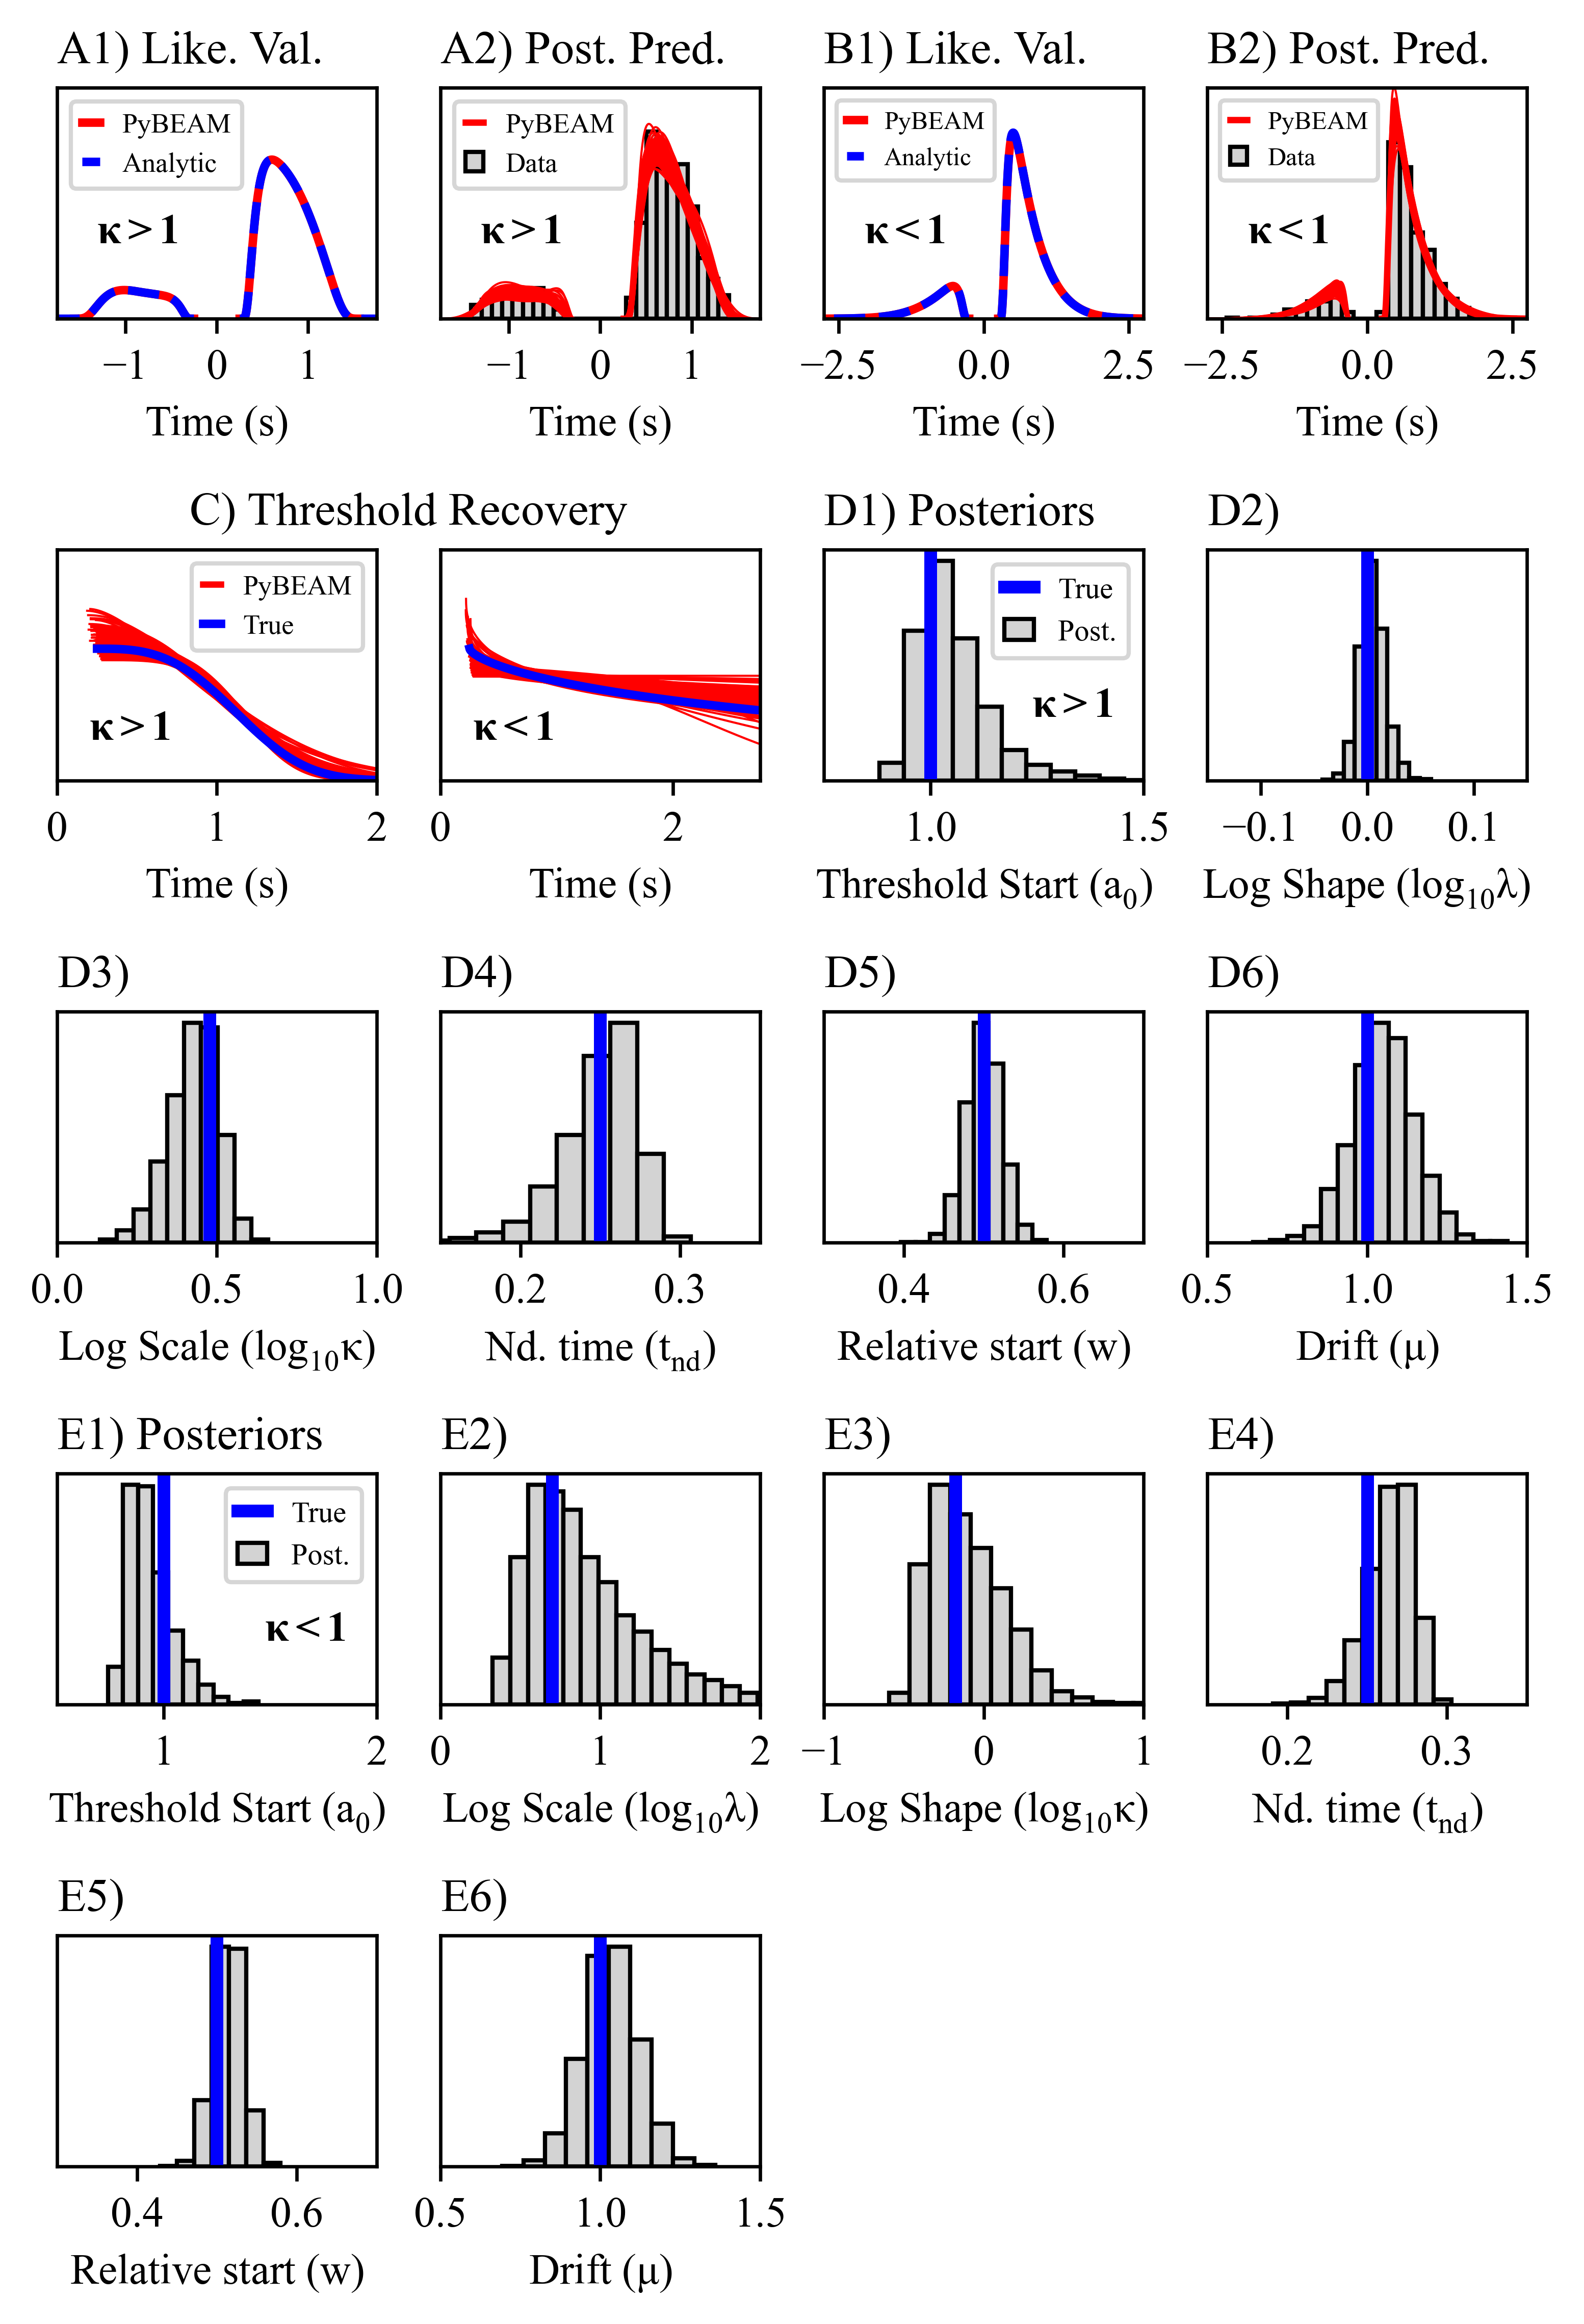

In [33]:
# -------------------------------------------------- #
# define figure
# -------------------------------------------------- #

fig, axs = plt.subplots(5, 4, figsize=(6.2, 9), dpi=600);
plt.subplots_adjust(hspace=1.0)

# -------------------------------------------------- #
# load trace data
# -------------------------------------------------- #

# weibull log-like trace
file_name = 'weibull_log'
burnin = 12500
trace = az.from_netcdf(file_name + '.nc')
trace = trace.sel(draw=slice(burnin,None))
trace = trace.posterior.stack(draws=("chain", "draw"))

t_nd_log = trace.t_nd.values
w_log = trace.w.values
mu_log = trace.mu.values
a_log = trace.a.values
lamb_log = trace.lamb.values
kappa_log = trace.kappa.values

# weibull exp-like trace
file_name = 'weibull_exp'
burnin = 25000
trace = az.from_netcdf(file_name + '.nc')
trace = trace.sel(draw=slice(burnin,None))
trace = trace.posterior.stack(draws=("chain", "draw"))

t_nd_exp = trace.t_nd.values
w_exp = trace.w.values
mu_exp = trace.mu.values
a_exp = trace.a.values
lamb_exp = trace.lamb.values
kappa_exp = trace.kappa.values

# -------------------------------------------------- #
# generate panel [0,0]
# -------------------------------------------------- #

model_rt = pbd.model_rt(model = model, phi = phi_log)
axs[0,0].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'red', linewidth = 2.0)
axs[0,0].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'red', linewidth = 2.0, label = '_nolegend_')

# import analytic solutions
t_log = np.loadtxt('t_log.csv', delimiter = ',')
rt_upper_log = np.loadtxt('rt_upper_log.csv', delimiter = ',')
rt_lower_log = np.loadtxt('rt_lower_log.csv', delimiter = ',')
axs[0,0].plot(t_log + phi_log['t_nd'], rt_upper_log, color = 'b', linestyle = '--', linewidth = 2.0)
axs[0,0].plot(-(t_log + phi_log['t_nd']), rt_lower_log, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2.0)

axs[0,0].set_xlim(-1.75, 1.75)
axs[0,0].set_title('A1) Like. Val.', loc = 'left', fontsize = 11)
axs[0,0].set_xlabel('Time (s)')
leg00 = axs[0,0].legend(['PyBEAM', 'Analytic'], fontsize = 6.5, handlelength = 0.65, loc = 'upper left')

# -------------------------------------------------- #
# generate panel [0,1]
# -------------------------------------------------- #

# plot logistic weibull posterior predictive
rt_log_all = np.concatenate((rt_log['rt_upper'], -rt_log['rt_lower']))
axs[0,1].hist(rt_log_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');

N_pp = 100
for ii in range(N_pp):
    
    ind = np.random.randint(0, len(t_nd_log))
    t_nd_ind = t_nd_log[ind]
    w_ind = w_log[ind]
    mu_ind = mu_log[ind]
    a_ind = a_log[ind]
    lamb_ind = lamb_log[ind]
    kappa_ind = kappa_log[ind]   
    
    phi_temp = {'t_nd' : t_nd_ind,
                   'w' : w_ind,
                  'mu' : mu_ind,
                   'a' : a_ind,
                'lamb' : lamb_ind,
               'kappa' : kappa_ind,
                   'c' : -1.0}
       
    rt_model = pbd.model_rt(model = model, phi = phi_temp)
    if (ii == 0):
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')
    
axs[0,1].set_xlim(-1.75, 1.75)
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_title('A2) Post. Pred.', loc = 'left', fontsize = 11)
axs[0,1].legend(['PyBEAM', 'Data'], fontsize = 6.5, loc = 'upper left', handlelength = 0.65)

# -------------------------------------------------- #
# generate panel [1,0]
# -------------------------------------------------- #

# plot logistic weibull boundary predictive

t = np.linspace(0.0, 2.5, 10000)

N_pp = 100
for ii in range(N_pp):
    ind = np.random.randint(0, len(t_nd_log))
    t_nd_ind = t_nd_log[ind]
    a_ind = a_log[ind]
    lamb_ind = 10**lamb_log[ind]
    kappa_ind = 10**kappa_log[ind]    
    bu = a_ind - a_ind*( 1.0 - np.exp( -(t/lamb_ind)**(kappa_ind) ) )
    if (ii == 0):
        axs[1,0].plot(t + t_nd_ind, bu, color = 'r')
    else:
        axs[1,0].plot(t + t_nd_ind, bu, color = 'r', linewidth = 0.5, label = '_nolegend_')

t_nd = phi_log['t_nd']
a = phi_log['a']
lamb = 10**phi_log['lamb']
kappa = 10**phi_log['kappa']
bu = a - a*( 1.0 - np.exp( -(t/lamb)**(kappa) ) )  
axs[1,0].plot(t + t_nd, bu, color = 'b', linewidth = 2);
        
axs[1,0].legend(['PyBEAM', 'True'], fontsize = 6.5, loc = 'upper right', handlelength = 0.65)
axs[1,0].set_title('C) Threshold Recovery', fontsize = 11, x = 1.1)
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylim(0.0, 1.75)
axs[1,0].set_xlim(0.0, 2.0)

# -------------------------------------------------- #
# generate panel [0,2]
# -------------------------------------------------- #

# simulate exponential weibull validation values
model_rt = pbd.model_rt(model = model, phi = phi_exp)
axs[0,2].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'red', linewidth = 2)
axs[0,2].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'red', linewidth = 2, label = '_nolegend_')

t_exp = np.loadtxt('t_exp.csv', delimiter = ',')
rt_upper_exp = np.loadtxt('rt_upper_exp.csv', delimiter = ',')
rt_lower_exp = np.loadtxt('rt_lower_exp.csv', delimiter = ',')
axs[0,2].plot(t_exp + phi_exp['t_nd'], rt_upper_exp, color = 'b', linestyle = '--', linewidth = 2)
axs[0,2].plot(-(t_exp + phi_exp['t_nd']), rt_lower_exp, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2)

axs[0,2].set_title('B1) Like. Val.', loc = 'left', fontsize = 11)
axs[0,2].set_xlabel('Time (s)')
axs[0,2].legend(['PyBEAM', 'Analytic'], fontsize = 6.0, loc = 'upper left', handlelength = 0.65)
axs[0,2].set_xlim([-2.75, 2.75])

# -------------------------------------------------- #
# generate panel [0,3]
# -------------------------------------------------- #

# plot exp weibull posterior predictive
rt_exp_all = np.concatenate((rt_exp['rt_upper'], -rt_exp['rt_lower']))
axs[0,3].hist(rt_exp_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');

N_pp = 100
for ii in range(N_pp):
    ind = np.random.randint(0, len(t_nd_exp))
    t_nd_ind = t_nd_exp[ind]
    w_ind = w_exp[ind]
    mu_ind = mu_exp[ind]
    a_ind = a_exp[ind]
    lamb_ind = lamb_exp[ind]
    kappa_ind = kappa_exp[ind]   
    
    phi_temp = {'t_nd' : t_nd_ind,
                   'w' : w_ind,
                  'mu' : mu_ind,
                   'a' : a_ind,
                'lamb' : lamb_ind,
               'kappa' : kappa_ind,
                   'c' : -1.0}
    
    rt_model = pbd.model_rt(model = model, phi = phi_temp)
    if (ii == 0):
        axs[0,3].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,3].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,3].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,3].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')

axs[0,3].set_xlabel('Time (s)')
axs[0,3].set_xlim([-2.75, 2.75])
axs[0,3].set_title('B2) Post. Pred.', loc = 'left', fontsize = 11)
axs[0,3].legend(['PyBEAM', 'Data'], fontsize = 6.0, loc = 'upper left', handlelength = 0.65)

# -------------------------------------------------- #
# generate panel [1,1]
# -------------------------------------------------- #

# plot exponential weibull boundary predictive

t = np.linspace(0.0, 2.5, 10000)

N_pp = 100
for ii in range(N_pp):
    ind = np.random.randint(0, len(t_nd_exp))
    t_nd_ind = t_nd_exp[ind]
    a_ind = a_exp[ind]
    lamb_ind = 10**lamb_exp[ind]
    kappa_ind = 10**kappa_exp[ind]    
    bu = a_ind - a_ind*( 1.0 - np.exp( -(t/lamb_ind)**(kappa_ind) ) )
    axs[1,1].plot(t + t_nd_ind, bu, color = 'r', linewidth = 0.5)
    
t_nd = phi_exp['t_nd']
a = phi_exp['a']
lamb = 10**phi_exp['lamb']
kappa = 10**phi_exp['kappa']
bu = a - a*( 1.0 - np.exp( -(t/lamb)**(kappa) ) )  
axs[1,1].plot(t + t_nd, bu, color = 'b', linewidth = 2)

axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylim(0.0, 1.75)
axs[1,1].set_xlim(0.0, 2.75)

# -------------------------------------------------- #
# generate panels [1,2] ; [1,3] ; [2,0]
# -------------------------------------------------- #

axs[1,2].hist(a_log, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,2].axvline(x=1.0, c = 'b', linewidth = 3)
axs[1,2].set_xlim(0.75, 1.5)
axs[1,2].set_xlabel('Threshold Start ($a_{0}$)')
axs[1,2].set_title('D1) Posteriors', loc = 'left', fontsize = 11)
axs[1,2].legend(['True', 'Post.'], fontsize = 7, handlelength = 1.0, loc = 'upper right')

axs[1,3].hist(lamb_log, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,3].axvline(x=np.log10(1.0), c = 'b', linewidth = 3)
axs[1,3].set_xlim(-0.15, 0.15)
axs[1,3].set_title('D2)', loc = 'left', fontsize = 11)
axs[1,3].set_xlabel('Log Shape ($log_{10} \lambda$) ')

axs[2,0].hist(kappa_log, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,0].axvline(x=np.log10(3.0), c = 'b', linewidth = 3)
axs[2,0].set_xlim(0.0, 1.0)
axs[2,0].set_title('D3)', loc = 'left', fontsize = 11)
axs[2,0].set_xlabel('Log Scale ($log_{10} \kappa$)');

axs[2,1].hist(t_nd_log, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,1].axvline(x=0.25, c = 'b', linewidth = 3)
axs[2,1].set_xlabel('Nd. time ($t_{nd}$)')
axs[2,1].set_title('D4)', loc = 'left', fontsize = 11)
axs[2,1].set_xlim(0.15, 0.35)

axs[2,2].hist(w_log, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,2].axvline(x=0.5, c = 'b', linewidth = 3)
axs[2,2].set_xlabel('Relative start ($w$)')
axs[2,2].set_title('D5)', loc = 'left', fontsize = 11)
axs[2,2].set_xlim(0.3, 0.7)

axs[2,3].hist(mu_log, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,3].axvline(x=1.0, c = 'b', linewidth = 3)
axs[2,3].set_xlabel('Drift ($\mu$)')
axs[2,3].set_title('D6)', loc = 'left', fontsize = 11)
axs[2,3].set_xlim(0.5, 1.5)
    
# -------------------------------------------------- #
# generate panel [2,1] ; [2,2] ; [2,3]
# -------------------------------------------------- #
    
axs[3,0].hist(a_exp, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[3,0].set_xlabel('Threshold Start ($a_{0}$)')
axs[3,0].axvline(x=1.0, c = 'b', linewidth = 3)
axs[3,0].set_xlim(0.5, 2.0)
axs[3,0].set_title('E1) Posteriors', loc = 'left', fontsize = 11)
axs[3,0].legend(['True', 'Post.'], fontsize = 7, handlelength = 1.0, loc = 'upper right')

axs[3,1].hist(lamb_exp, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[3,1].axvline(x=np.log10(5.0), c = 'b', linewidth = 3)
axs[3,1].set_xlabel('Log Scale ($log_{10} \lambda$)')
axs[3,1].set_title('E2)', loc = 'left', fontsize = 11)
axs[3,1].set_xlim(0.0, 2.0)

axs[3,2].hist(kappa_exp, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[3,2].axvline(x=np.log10(0.666), c = 'b', linewidth = 3)
axs[3,2].set_xlabel('Log Shape ($log_{10} \kappa$)')
axs[3,2].set_title('E3)', loc = 'left', fontsize = 11)
axs[3,2].set_xlim(-1.0, 1.0)

axs[3,3].hist(t_nd_exp, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[3,3].axvline(x=0.25, c = 'b', linewidth = 3)
axs[3,3].set_xlabel('Nd. time ($t_{nd}$)')
axs[3,3].set_title('E4)', loc = 'left', fontsize = 11)
axs[3,3].set_xlim(0.15, 0.35)

axs[4,0].hist(w_exp, density = True, bins = 7, edgecolor = 'k', facecolor = 'lightgrey');
axs[4,0].axvline(x=0.5, c = 'b', linewidth = 3)
axs[4,0].set_xlabel('Relative start ($w$)')
axs[4,0].set_title('E5)', loc = 'left', fontsize = 11)
axs[4,0].set_xlim(0.3, 0.7)

axs[4,1].hist(mu_exp, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[4,1].axvline(x=1.0, c = 'b', linewidth = 3)
axs[4,1].set_xlabel('Drift ($\mu$)')
axs[4,1].set_title('E6)', loc = 'left', fontsize = 11)
axs[4,1].set_xlim(0.5, 1.5)

# -------------------------------------------------- #
# modify axes and labels
# -------------------------------------------------- #

for ii in range(1):
    for jj in range(4):
        axs[ii,jj].set_ylim([0.0, 1.75])

for ii in range(5):
    for jj in range(4):
        axs[ii,jj].set_yticklabels([])
        axs[ii,jj].set_yticks([])
        
for ii in range(0,2):
    axs[0,ii].text(0.125, 0.45, '$\kappa > 1$', transform=axs[0,ii].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
for ii in range(2,4):
    axs[0,ii].text(0.125, 0.45, '$\kappa < 1$', transform=axs[0,ii].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
    
axs[1,0].text(0.1, 0.3, '$\kappa > 1$', transform=axs[1,0].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
axs[1,1].text(0.1, 0.3, '$\kappa < 1$', transform=axs[1,1].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');

axs[1,2].text(0.65, 0.4, '$\kappa > 1$', transform=axs[1,2].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
axs[3,0].text(0.65, 0.4, '$\kappa < 1$', transform=axs[3,0].transAxes, fontsize=10, fontweight = 'bold', verticalalignment='top');
        
axs[4,2].set_axis_off()
axs[4,3].set_axis_off()
    
plt.savefig('weibull_full.pdf', bbox_inches = 'tight', dpi = 600)
